In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from copy import deepcopy

In [118]:
# Euclidean Distance Caculator
def euclidean(a, b, ax=1):
    return np.linalg.norm(a-b, axis=ax)

In [142]:
class CustomKMeans:
    def __init__(self, n_clusters=8, init="random", max_iter=300, tol = 0.0001):
        '''
        Parameters: n_clusters: int, optional, default: 8
                        The number of clusters to form as well as the number
                        of centroids to generate
                    
                    init: {'random' or an ndarray}
                        Method for initialization, defaults to 'random'
                        
                        'random': choose k observations(rows) at random
                                  from data for the initial centroids
                        
                        If an ndarray is passed, it should be of shape 
                        (n_clusters, n_features) and gives the initial
                        centroids
                    
                    max_iter: int, optional, default: 300
                        Maximum number of iterations of the k-means
                        algorithm in a single run
                    
                    tol: float, optional, default: 0.0001
                        Relative tolerance with respect to inertia to
                        declare convergence
        '''
        if n_clusters > 0:
            self.n_clusters = n_clusters
        else:
            raise ValueError("n_clusters must be an int greater than 0.")
        if isinstance(init, str) and init != "random":
            raise ValueError("init parameter can only have value random or be a ndarray "
                             "of shape (n_clusters, n_features).")
        elif not hasattr(init, '__array__'):
            raise ValueError("init parameter can only have value random or be a ndarray "
                             "of shape (n_clusters, n_features).")
        else:
            self.init = init
        if max_iter > 0:
            self.max_iter = max_iter
        else:
            raise ValueError("max_iter must be an int greater than 0.")
        if tol > 0:
            self.tol = tol
        else:
            raise ValueError("tol must be a float greater than 0.")

    def check_input(self, X, y=None):
        '''
            Description: Checks if the input is a Pandas DataFrame,
                         Pandas Series or Numpy array
            
            Parameters: X: Data
                        y: Target values
                        
            Returns: ValueError if input is invalid
                     True otherwise
        '''
        if not isinstance(X, (pd.Series, pd.DataFrame, np.ndarray)):
            error = """ X required as a Pandas DataFrame, 
                        Pandas Series or a Numpy array. Found type: {datatype_x}
                    """.format(datatype_x=type(X))
            raise TypeError(error)
        if y is not None and not isinstance(y, (pd.Series, pd.DataFrame, np.ndarray)):
            error = """ y required as a Pandas DataFrame, 
                        Pandas Series or a Numpy array. Found type: {datatype_y}
                    """.format(datatype_y=type(y))
            raise TypeError(error)
        return True
    
    def transform_input(self, X, y=None):
        '''
            Description: Transforms the input into 2D numpy array before fitting the model
            
            Parameters: X: Data
                        y: Target values
                        
            Returns: If input is of valid format:
                         X: Returns data X as a 2D numpy array
                         y: Returns target y as a 2D numpy array
                     Otherwise returns the input as it is
        '''
        if self.check_input(X, y):
            # Convert X into numpy array
            if isinstance(X, pd.DataFrame):
                X = X.values
            elif isinstance(X, pd.Series):
                X = X.values
                X = X[:, None]
            # Convert y into numpy array
            if y is not None:
                if isinstance(y, pd.DataFrame):
                    y = y.values
                elif isinstance(y, pd.Series):
                    y = y.values
                    y = y[:, None]
        if y is None:
            return X
        else:
            return X, y
    
    def _init_centroids(self, X):
        '''
        Parameters: X: array, shape (n_samples, n_features)
                        The dataset using which clusters need
                        to be found.
        Returns: centres: array, shape(n_clusters, n_features)
                            Initial centroids
        '''
        n_samples = X.shape[0]
        if isinstance(self.init, str):
            seeds = np.random.permutation(n_samples)[:self.n_clusters]
            centers = X[seeds]
        else:
            centers = np.array(self.init)
        if len(centers) != self.n_clusters:
            raise ValueError("The shape of the initial centers {} "
                             "does not match the number of clusters {}"
                             .format(centers.shape, self.n_clusters))
        if centers.shape[1] != X.shape[1]:
            raise ValueError("The number of features of the initial centers {} "
                             "does not match the number of features of the data {}."
                             .format(centers.shape[1], X.shape[1]))
        return centers
    
    def fit(self, X):
        '''
        Parameters: X: array, shape(n_samples, n_features)
                        The dataset using which clusters need
                        to be found.
        '''
        X = self.transform_input(X)
        self.cluster_centers_ = self._init_centroids(X)
        
        for i in range(self.max_iter):
            self.labels_ = np.zeros(len(X), dtype=np.int64)
            self.inertia_ = np.zeros(len(X))
            previous_clusters_ = np.zeros(self.cluster_centers_.shape)
            for j in range(len(X)):
                # Calculate distances to all centroids
                distances = euclidean(X[j], self.cluster_centers_)
                # Label for given datapoint is centroid with smallest distance value
                self.labels_[j] = np.argmin(distances)
                # Store the smallest distance value as inertia of datapoint
                self.inertia_[j] = np.amin(distances)
            previous_clusters = deepcopy(self.cluster_centers_)
            # Finding the new centroids by taking the average value
            for j in range(self.n_clusters):
                points = [X[k] for k in range(len(X)) if self.labels_[k] == j]
                self.cluster_centers_[j] = np.mean(points, axis=0)
            # Check if kmeans has already converged
            if euclidean(self.cluster_centers_, previous_clusters, None) <= self.tol:
                break
        return self
            

    def predict(self, X):
        '''
        Parameters: X: array, shape(n_samples, n_features)
                        Datapoints whose labels need to be
                        predicted.
        Returns: labels: array, shape(n_samples,)
                            Predicted labels of all points
                            in X.
        '''
        X = self.transform_input(X)
        labels = np.zeros(len(X), dtype=np.int64)
        for i in range(len(X)):
            distances = euclidean(X[i], self.cluster_centers_)
            labels[i] = np.argmin(distances)
        return labels

In [97]:
dataset = pd.read_csv('dataset.csv')
dataset.head(20)

,Points,X,Y
0,P1,0.10,0.60
1,P2,0.15,0.71
2,P3,0.08,0.90
3,P4,0.16,0.85
4,P5,0.20,0.30
5,P6,0.25,0.50
6,P7,0.24,0.10
7,P8,0.30,0.20


In [98]:
dataset = dataset.drop(['Points'], axis=1)
dataset.head(20)

,X,Y
0,0.10,0.60
1,0.15,0.71
2,0.08,0.90
3,0.16,0.85
4,0.20,0.30
5,0.25,0.50
6,0.24,0.10
7,0.30,0.20


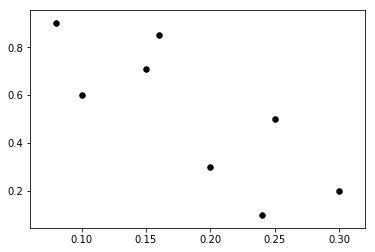

In [99]:
# Visualize the points before clustering
plt.scatter(dataset['X'], dataset['Y'], c='black', s=30)

In [116]:
# Generate training dataset
X = np.array(list(zip(dataset['X'], dataset['Y'])))
# Set the initial centroids as P1 and P8
initial_centroids = np.array([X[0], X[7]])
print("Inital centroids are : {}".format(initial_centroids))

Inital centroids are : [[0.1 0.6]
 [0.3 0.2]]


P6 belongs to cluster: 0
Population of cluster around M2: 3
Updated value of m1 and m2: [[0.148      0.712     ]
 [0.24666667 0.2       ]]


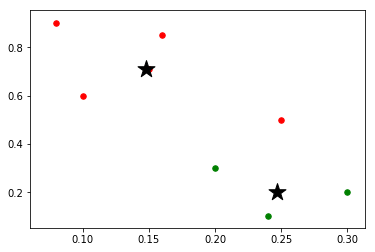

In [145]:
# Run Custom KMeans and find the clusters
custom_kmeans = CustomKMeans(n_clusters=2, init=initial_centroids)
labels = custom_kmeans.fit(X).predict(X)
centroids = custom_kmeans.cluster_centers_
# Which cluster does P6 belong to?
print("P6 belongs to cluster: {}".format(labels[5]))
# What is the population of cluster around m2?
points_in_m2 = np.array([X[i] for i in range(len(X)) if labels[i]==1])
print("Population of cluster around M2: {}".format(len(points_in_m2)))
# What is updated value of m1 and m2?
print("Updated value of m1 and m2: {}".format(centroids))
# Visualize the clusters identified by custom KMeans
colors = ['red', 'green']
fig, ax = plt.subplots()
for i in range(len(centroids)):
    points = np.array([X[j] for j in range(len(X)) if labels[j]==i])
    ax.scatter(points[:, 0], points[:, 1], s=30, c=colors[i])
ax.scatter(centroids[:, 0], centroids[:, 1], marker="*", s=320, c='black')

P6 belongs to cluster: 0
Population of cluster around M2: 3
Updated value of m1 and m2: [[0.148      0.712     ]
 [0.24666667 0.2       ]]


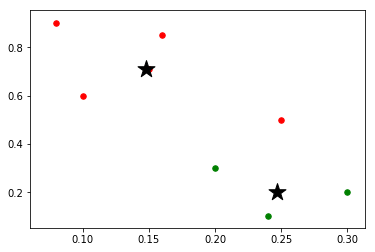

In [139]:
# Run Sklearn KMeans and find the clusters
sklearn_kmeans = KMeans(n_clusters=2, init=initial_centroids, n_init=1)
labels = sklearn_kmeans.fit(X).predict(X)
centroids = sklearn_kmeans.cluster_centers_
# Which cluster does P6 belong to?
print("P6 belongs to cluster: {}".format(labels[5]))
# What is the population of cluster around m2?
points_in_m2 = np.array([X[i] for i in range(len(X)) if labels[i]==1])
print("Population of cluster around M2: {}".format(len(points_in_m2)))
# What is updated value of m1 and m2?
print("Updated value of m1 and m2: {}".format(centroids))
# Visualize the clusters identified by sklearn KMeans
colors = ['red', 'green']
fig, ax = plt.subplots()
for i in range(len(centroids)):
    points = np.array([X[j] for j in range(len(X)) if labels[j]==i])
    ax.scatter(points[:, 0], points[:, 1], s=30, c=colors[i])
ax.scatter(centroids[:, 0], centroids[:, 1], marker="*", s=320, c='black')